In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

Checking chessboard 15x5...


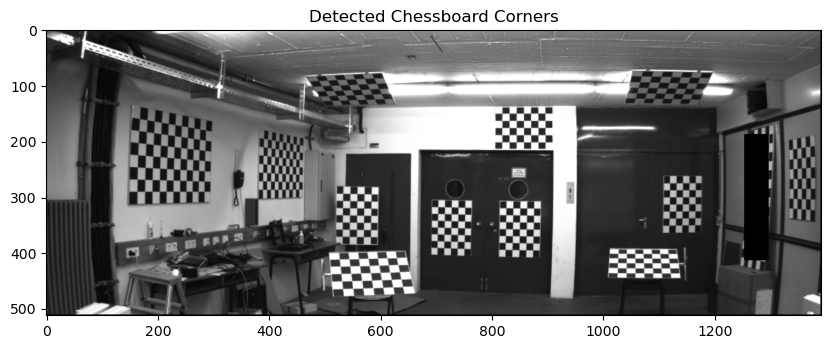

Checking chessboard 11x7...


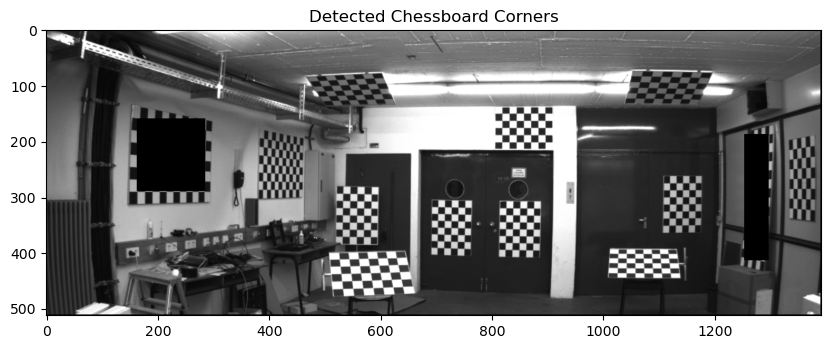

Checking chessboard 7x5...


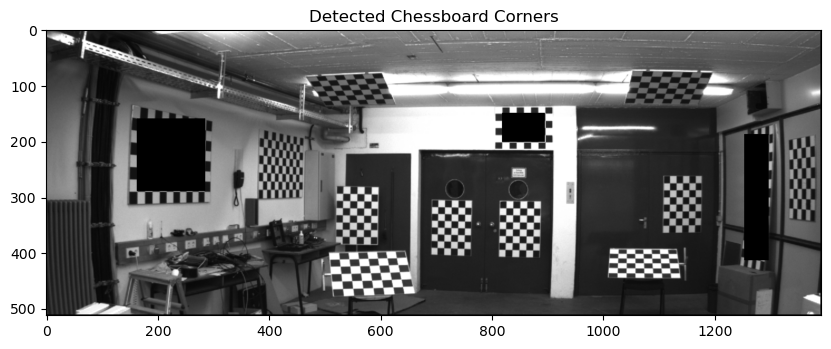

Checking chessboard 7x5...


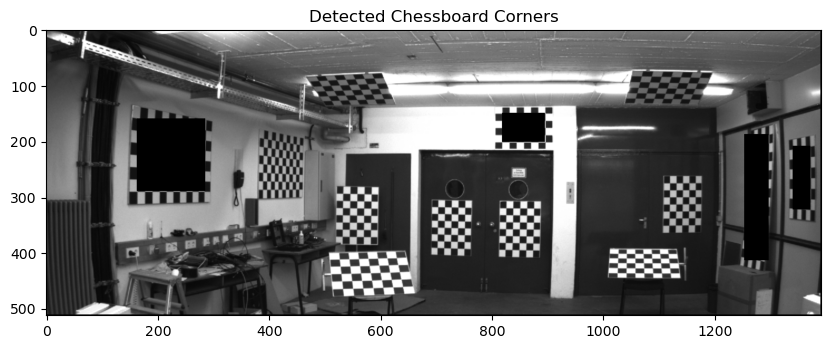

Checking chessboard 7x5...


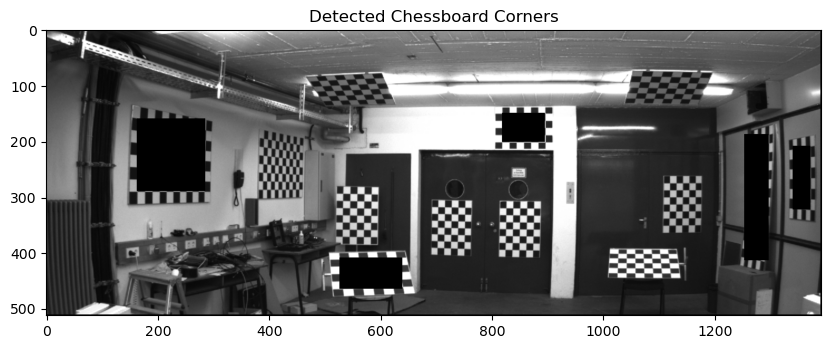

Checking chessboard 7x5...


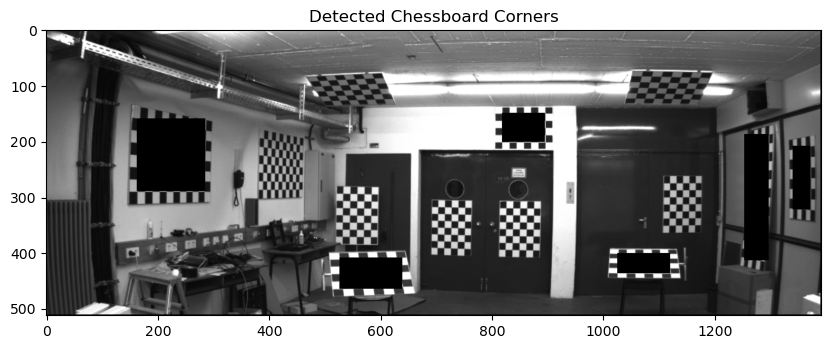

Checking chessboard 7x5...


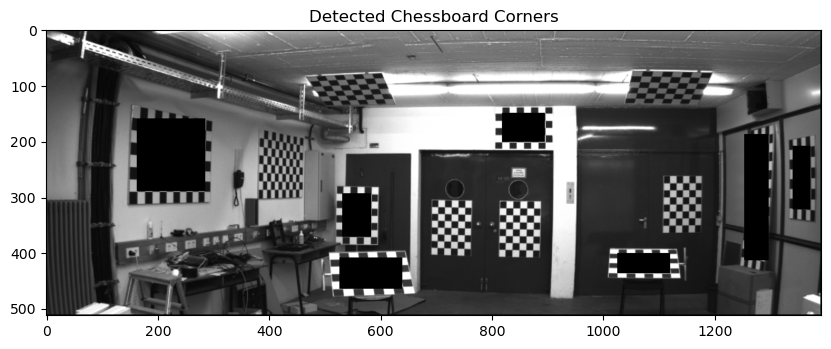

Checking chessboard 5x7...


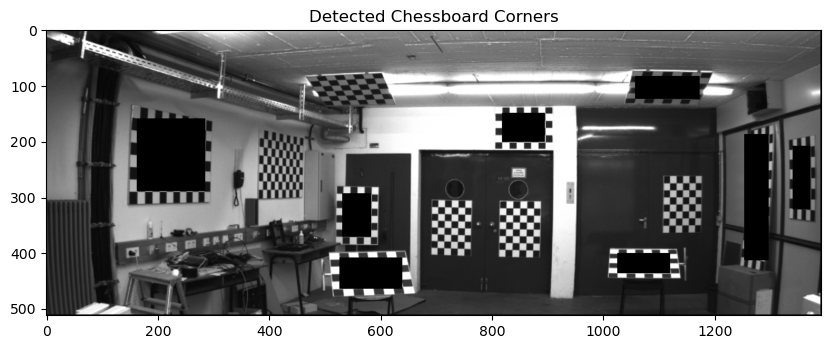

Checking chessboard 5x7...


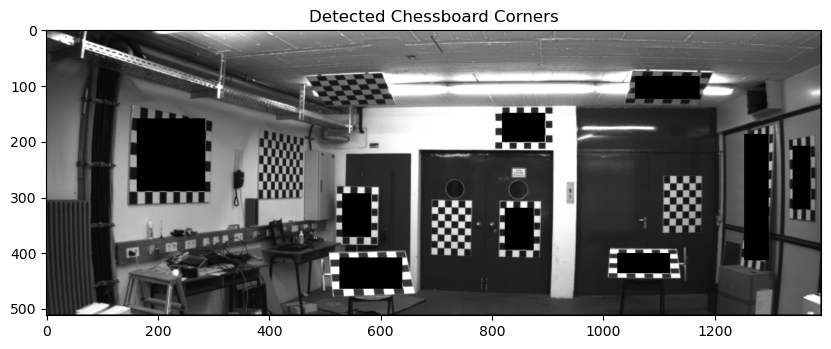

Checking chessboard 5x7...


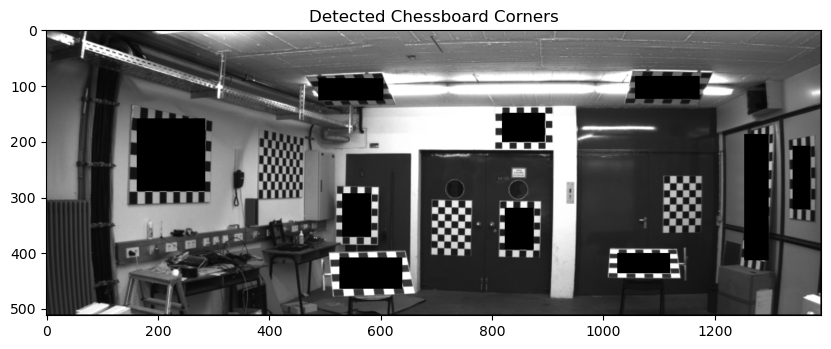

Checking chessboard 11x7...


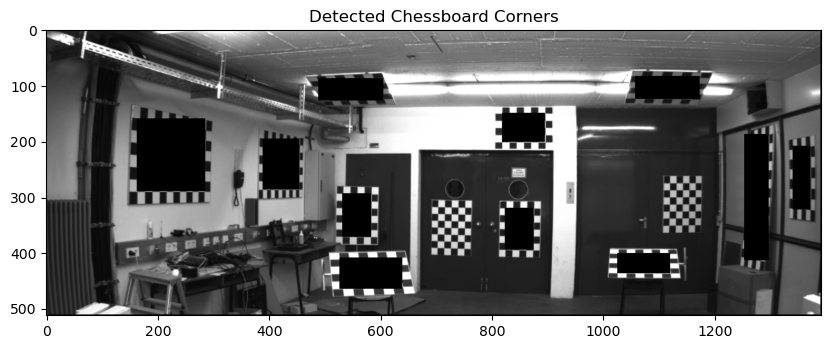

In [7]:
# Load the image (replace with the path to your uploaded image)
image_path = '../34759_final_project_rect/calib/image_02/data/'
# List of chessboards with their respective number of internal corners (vertical, horizontal)
chessboards = [
    (15,5),
    (11,7),
    (11,7),
    (5,7),
    (7,5),
    (5,7),
    (7,5),
    (5,7),
    (7,5),
    (7,5),
    (7,7),
    (7,5),
    (7,5),
    (7,5),
    (5,7),
    (5,7),
    (7,5),
    (5,7)
]

found_areas = []
objpoints = []  # 3D points in real-world space
imgpoints = []  # 2D points in image plane

for image in os.listdir(image_path):
    img = cv2.imread(image_path + image)
    # Check if the image was successfully loaded
    if img is None:
        print('Error: Unable to load image')
        continue

    # Convert to grayscale for corner detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for i in found_areas:
        x_min, y_min, x_max, y_max = i
        gray[y_min:y_max, x_min:x_max] = 0


    # Loop through each chessboard's configuration (different number of internal corners)
    for nb_vertical, nb_horizontal in chessboards:
        # Prepare object points for this specific chessboard (3D points in real-world space)
        objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

        # Detect chessboard corners for this chessboard size
        ret, corners = cv2.findChessboardCorners(
                gray, (nb_vertical, nb_horizontal),
                flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
            )


        if ret: 
            print(f'Checking chessboard {nb_vertical}x{nb_horizontal}...')
            objpoints.append(objp)  # 3D points
            imgpoints.append(corners)  # 2D points

            # Create a bounding box around the detected corners
            x_min, y_min = np.int32(corners.min(axis=0).ravel())
            x_max, y_max = np.int32(corners.max(axis=0).ravel())

            found_areas.append((x_min, y_min, x_max, y_max))

            # Set all values inside the bounding box to 0
            gray[y_min:y_max, x_min:x_max] = 0

            #Delete the elements in chessboards that have been found
            chessboards.remove((nb_vertical, nb_horizontal))    


            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
            #for corners in imgpoints:
            #    if corners is not None:
            #        plt.plot(corners[:, 0, 0], corners[:, 0, 1], 'ro', markersize=5)
            plt.title('Detected Chessboard Corners')
            plt.show()

   

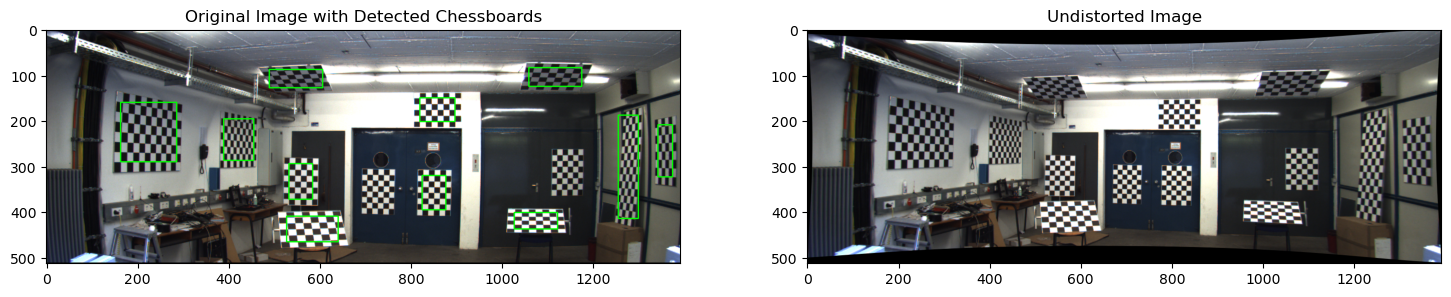

In [8]:
# Perform camera calibration using all the detected chessboards
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Get the optimal camera matrix
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# Undistort the original image
undistorted_img = cv2.undistort(img, mtx, dist, None, newcameramtx)


for i in found_areas:
    x_min, y_min, x_max, y_max = i
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)


# Display the original and undistorted images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 18))
ax[0].imshow(img[..., [2, 1, 0]])  # Convert BGR to RGB for matplotlib
ax[0].set_title('Original Image with Detected Chessboards')
ax[1].imshow(undistorted_img[..., [2, 1, 0]])  # Convert BGR to RGB for matplotlib
ax[1].set_title('Undistorted Image')

plt.show()

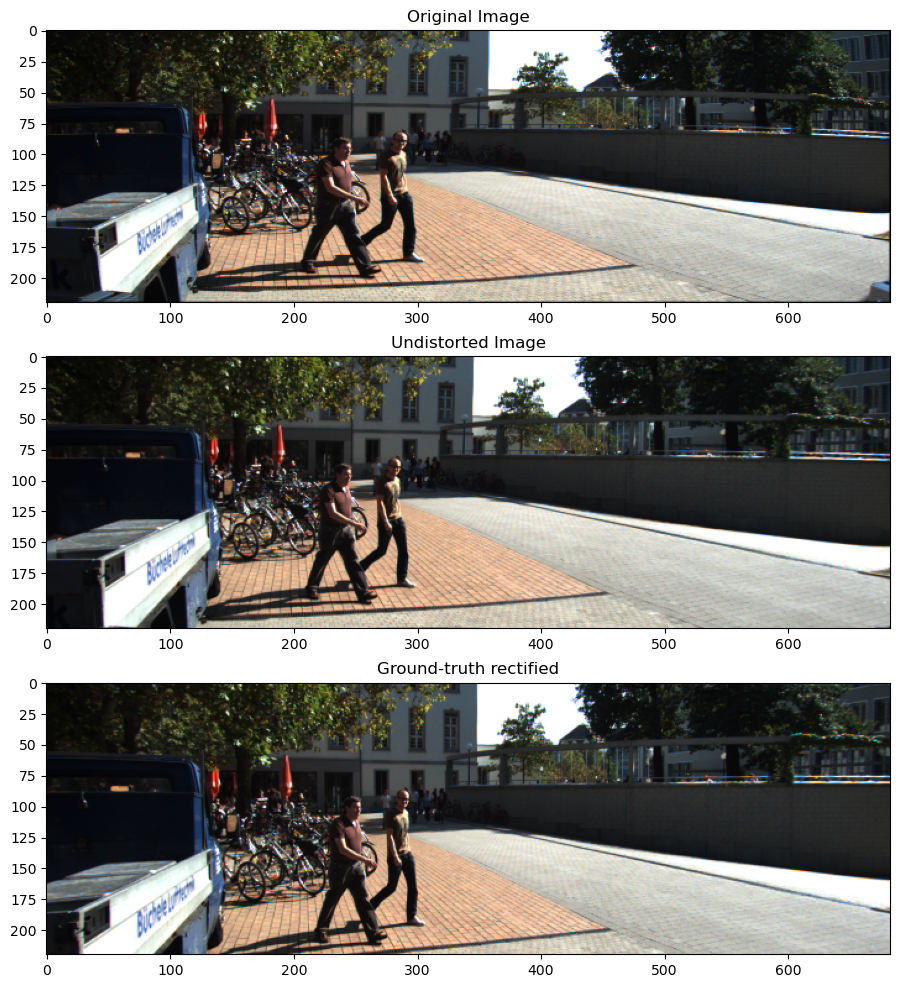

In [9]:
#apply the rectification to a new image
image_path = '../34759_final_project_raw/seq_01/image_02/data/'
img = cv2.imread(image_path + '0000000000.png')
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
undistorted_img = cv2.undistort(img, mtx, dist, None, newcameramtx)

#Crop the undistorted image so that it only shows the non-black pixels
x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]


#save the image
cv2.imwrite('undistorted.png', undistorted_img)


#load another image
image_path_rect = '../34759_final_project_rect/seq_01/image_02/data/'
img_rect = cv2.imread(image_path_rect + '000000.png')


# Resize all images to a smaller size
target_size = (int(undistorted_img.shape[1] * 0.5), int(undistorted_img.shape[0] * 0.5))  # (width, height)

img_resized = cv2.resize(img, target_size)
img_rect_resized = cv2.resize(img_rect, target_size)
undistorted_img_resized = cv2.resize(undistorted_img, target_size)

# Display the original, undistorted, and rectified images
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
ax[0].imshow(img_resized[..., [2, 1, 0]])  # Convert BGR to RGB for matplotlib
ax[0].set_title('Original Image')
ax[1].imshow(undistorted_img_resized[..., [2, 1, 0]])  # Convert BGR to RGB for matplotlib
ax[1].set_title('Undistorted Image')
ax[2].imshow(img_rect_resized[..., [2, 1, 0]])  # Convert BGR to RGB for matplotlib
ax[2].set_title('Ground-truth rectified')

plt.show()

#save the plot
fig.savefig('undistorted_rectified.png')




In [10]:
#save the parameters for rectification
np.savez('calibration.npz', mtx=mtx, dist=dist, newcameramtx=newcameramtx, roi=roi)


In [ ]:
#make a function to rectify an image
def rectify_image(img, calibration_file='calibration.npz'):
    # Load the calibration parameters
    with np.load(calibration_file) as data:
        mtx = data['mtx']
        dist = data['dist']
        newcameramtx = data['newcameramtx']
        roi = data['roi']

    # Undistort the original image
    undistorted_img = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # Crop the undistorted image so that it only shows the non-black pixels
    x, y, w, h = roi
    undistorted_img = undistorted_img[y:y+h, x:x+w]

    return undistorted_img


#make an class that rectifies an image 


class ImageRectifier:
    def __init__(self, calibration_file='calibration.npz'):
        # Load the calibration parameters
        with np.load(calibration_file) as data:
            self.mtx = data['mtx']
            self.dist = data['dist']
            self.newcameramtx = data['newcameramtx']
            self.roi = data['roi']

    def rectify(self, img):
        # Undistort the original image
        undistorted_img = cv2.undistort(img, self.mtx, self.dist, None, self.newcameramtx)

        # Crop the undistorted image so that it only shows the non-black pixels
        x, y, w, h = self.roi
        undistorted_img = undistorted_img[y:y+h, x:x+w]

        return undistorted_img